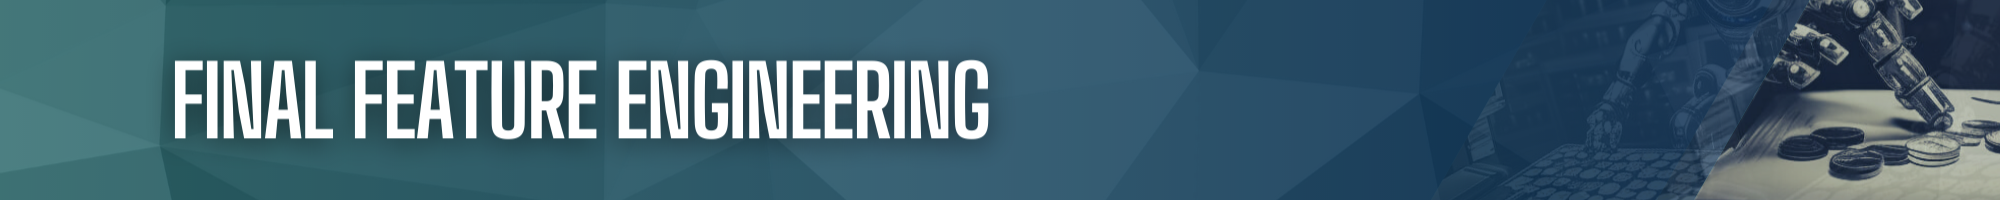

<div style="background-color: #f7f7f7; padding: 20px; border-radius: 10px; border: 2px solid #333333;">
<h2 style="font-family: Arial, sans-serif; color: #333333; text-align: center;">Gameplan</h2>
<ul style="font-family: Arial, sans-serif; color: #555555;">
<li><strong>Exploratory Data Analysis:</strong> Understand the data and its characteristics before model selection.</li>
<li><strong>Feature Engineering:</strong> Transform and create meaningful features to enhance model performance.</li>
<li><strong>Model Selection:</strong> Explore a variety of algorithms and techniques to identify the most suitable model.</li>
<li><strong>Hyperparameter Tuning:</strong> Optimize model performance by tuning hyperparameters through techniques like grid search or randomized search.</li>
<li><strong>Training and Validation:</strong> Split the data into training and validation sets for model training and evaluation.</li>
<li><strong>Model Training:</strong> Train the selected model on the training set using appropriate algorithms.</li>
</ul>
<h2 style="font-family: Arial, sans-serif; color: #333333; text-align: center;">Goal</h2>
<p style="font-family: Arial, sans-serif; color: #555555;">Utilize machine learning techniques to select and train the most suitable model for predicting coin rarity.</p>
</div>


In [77]:
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
from scipy.stats import shapiro, normaltest, kstest
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

In [78]:
# Load the dataset
file_path = os.path.join(os.getcwd(), 'Data', 'df_cleaned.csv')
df_cleaned = pd.read_csv(file_path)

In [79]:
def analyze_categorical_column(df, column_name):
    column_values = df[column_name]
    unique_values = column_values.unique()
    value_counts = column_values.value_counts()
    most_common_values = value_counts.head(5)  
    
    print(f"Column: {column_name}")
    print("Unique Values:")
    print(unique_values)
    print("\nValue Counts:")
    print(value_counts)
    print("\nMost Common Values:")
    print(most_common_values)

In [80]:
def determine_distribution_type(df, column_name):
    data = df[column_name].values
    
    # Shapiro-Wilk test for normality
    _, shapiro_pvalue = shapiro(data)
    
    # D'Agostino's K-squared test for normality
    _, dagostino_pvalue = normaltest(data)
    
    # Kolmogorov-Smirnov test for normality
    _, ks_pvalue = kstest(data, 'norm')
    
    # Check skewness and kurtosis to determine the distribution type
    skewness = df[column_name].skew()
    kurtosis = df[column_name].kurtosis()
    
    # Determine the distribution type based on the test results and characteristics
    if (shapiro_pvalue > 0.05 and dagostino_pvalue > 0.05 and ks_pvalue > 0.05):
        distribution_type = 'Normal'
    elif (skewness > 0 and kurtosis > 0):
        distribution_type = 'Positive Skew'
    elif (skewness < 0 and kurtosis < 0):
        distribution_type = 'Negative Skew'
    else:
        distribution_type = 'Unknown'
    
    if len(data) > 5000:
        distribution_type += " (p-value may not be accurate due to large sample size)"
    
    # Additional details
    frequency = df[column_name].value_counts().sort_index()
    distribution = df[column_name].describe()
    
    # Print out the details
    print("Distribution Type:", distribution_type)
    print("\nFrequency:")
    print(frequency)
    print("\nDistribution:")
    print(distribution)
    
    # Plot histogram
    plt.hist(data, bins='auto')
    plt.xlabel(column_name)
    plt.ylabel("Frequency")
    plt.title("Histogram of " + column_name)
    plt.show()
    
    return distribution_type

In [81]:
def feature_engineering(df):
    encoded_df = df.copy()

    # Drop the 'Title' column
    encoded_df.drop('Title', axis=1, inplace=True)

    # Drop the 'Thickness' column
    encoded_df.drop('Thickness', axis=1, inplace=True)
    
    # Drop the 'Century' column
    encoded_df.drop('Century', axis=1, inplace=True)

    # Convert 'Engraver' column to uint8
    encoded_df['Engraver'] = encoded_df['Engraver'].astype('uint8')

    # Replace "unknown" values in the 'Year' column with NaN and create 'Year_Missing' column
    encoded_df['Year'] = encoded_df['Year'].replace('unknown', np.nan)
    encoded_df['Year_Missing'] = encoded_df['Year'].isnull().astype(int)

    # Convert 'Year' column to numeric
    encoded_df['Year'] = pd.to_numeric(encoded_df['Year'], errors='coerce')

    # Replace "-1" values in the 'Mintage' column with NaN
    encoded_df['Mintage'] = encoded_df['Mintage'].replace(-1, np.nan)

    # Add 1 to every value in the 'Times Issued' column
    encoded_df['Times Issued'] = encoded_df['Times Issued'] + 1

    # Create the 'Mintage_Missing' column
    encoded_df['Mintage_Missing'] = encoded_df['Mintage'].isnull().astype(int)

    # Handle outliers in the 'Diameter' column
    max_threshold = np.percentile(encoded_df['Diameter'], 99)  # Set the maximum threshold for outliers
    encoded_df.loc[encoded_df['Diameter'] > max_threshold, 'Diameter'] = max_threshold

    # Scale the 'Diameter' column using MinMaxScaler
    scaler = MinMaxScaler()
    encoded_df['Diameter'] = scaler.fit_transform(encoded_df['Diameter'].values.reshape(-1, 1))

    # Normalize the "Rarity" column using MinMaxScaler
    scaler = MinMaxScaler()
    encoded_df['Rarity'] = scaler.fit_transform(encoded_df['Rarity'].values.reshape(-1, 1))

    # Perform one-hot encoding on the 'Edge' column
    encoded_df = pd.get_dummies(encoded_df, columns=['Edge'], prefix='Edge')

    # Perform one-hot encoding on the 'Composition' column
    encoded_df = pd.get_dummies(encoded_df, columns=['Composition'], prefix='Composition')

    # Perform one-hot encoding on the 'Demonetized' column
    encoded_df = pd.get_dummies(encoded_df, columns=['Demonetized'], prefix='Demonetized')

    # Perform one-hot encoding on the 'Orientation' column
    encoded_df = pd.get_dummies(encoded_df, columns=['Orientation'], prefix='Orientation')

    # Perform one-hot encoding on the 'Shape' column
    shape_encoder = LabelEncoder()
    encoded_df['Shape'] = shape_encoder.fit_transform(encoded_df['Shape'])
    encoded_df = pd.get_dummies(encoded_df, columns=['Shape'], prefix='Shape')
    encoded_df.rename(columns={'Shape_0': 'Shape_Round', 'Shape_1': 'Shape_Irregular'}, inplace=True)

    # Perform one-hot encoding on the 'Type' column
    encoded_df = pd.get_dummies(encoded_df, columns=['Type'], prefix='Type')

    # Perform one-hot encoding on the 'Technique' column
    encoded_df = pd.get_dummies(encoded_df, columns=['Technique'], prefix='Technique')

    # Label encode the 'Issuer' column
    issuer_encoder = LabelEncoder()
    encoded_df['Issuer'] = issuer_encoder.fit_transform(encoded_df['Issuer'])

    # Save the mapping of the 'Issuer' encoding to a JSON file
    encoding_mapping = {str(label): original_value for label, original_value in enumerate(issuer_encoder.classes_)}
    folder_path = os.path.join(os.getcwd(), 'Data')
    file_path = os.path.join(folder_path, 'Issuer_encoding_dictionary.json')
    os.makedirs(folder_path, exist_ok=True)
    with open(file_path, 'w') as file:
        json.dump(encoding_mapping, file, indent=4)

    # Label encode the 'Currency' column
    currency_encoder = LabelEncoder()
    encoded_df['Currency'] = currency_encoder.fit_transform(encoded_df['Currency'])

    # Save the mapping of the 'Currency' encoding to a JSON file
    encoding_mapping = {str(label): original_value for label, original_value in enumerate(currency_encoder.classes_)}
    file_path = os.path.join(folder_path, 'Currency_encoding_dictionary.json')
    with open(file_path, 'w') as file:
        json.dump(encoding_mapping, file, indent=4)

    return encoded_df

In [82]:
def debug_feature_engineering(original_df, encoded_df):
    print("Feature Engineering Debug Report:")
    print("-" * 40)

    # Check if the "Title" column is dropped
    if "Title" not in encoded_df.columns:
        print("✓ The 'Title' column is successfully dropped.")
    else:
        print("✗ Failed to drop the 'Title' column.")
        
    # Check if the "Thickness" column is dropped
    if "Thickness" not in encoded_df.columns:
        print("✓ The 'Thickness' column is successfully dropped.")
    else:
        print("✗ Failed to drop the 'Thickness' column.")
        
    # Check if the "Century" column is dropped
    if "Century" not in encoded_df.columns:
        print("✓ The 'Century' column is successfully dropped.")
    else:
        print("✗ Failed to drop the 'Century' column.")

    # Check if the "Engraver" column is converted to uint8
    if encoded_df["Engraver"].dtype == 'uint8':
        print("✓ The 'Engraver' column is successfully converted to uint8.")
    else:
        print("✗ Failed to convert the 'Engraver' column to uint8.")

    # Check if "-1" values in the "Mintage" column are replaced with NaN
    if encoded_df["Mintage"].isnull().sum() > 0:
        print("✓ The '-1' values in the 'Mintage' column are successfully replaced with NaN.")
    else:
        print("✗ Failed to replace '-1' values in the 'Mintage' column with NaN.")

    # Check if 1 is added to every value in the "Times Issued" column
    if encoded_df["Times Issued"].min() > original_df["Times Issued"].min():
        print("✓ 1 is successfully added to every value in the 'Times Issued' column.")
    else:
        print("✗ Failed to add 1 to every value in the 'Times Issued' column.")

    # Check if the "Mintage_Missing" column is created
    if "Mintage_Missing" in encoded_df.columns:
        print("✓ The 'Mintage_Missing' column is successfully created.")
    else:
        print("✗ Failed to create the 'Mintage_Missing' column.")

    # Check if outliers in the "Diameter" column are handled
    max_threshold = np.percentile(original_df['Diameter'], 99)
    if encoded_df["Diameter"].max() <= max_threshold:
        print("✓ Outliers in the 'Diameter' column are successfully handled.")
    else:
        print("✗ Failed to handle outliers in the 'Diameter' column.")

    # Check if the "Diameter" column is scaled using MinMaxScaler
    if encoded_df["Diameter"].min() >= 0 and encoded_df["Diameter"].max() <= 1:
        print("✓ The 'Diameter' column is successfully scaled using MinMaxScaler.")
    else:
        print("✗ Failed to scale the 'Diameter' column using MinMaxScaler.")

    # Check if the "Rarity" column is scaled using MinMaxScaler
    if encoded_df["Rarity"].min() == 0 and encoded_df["Rarity"].max() == 1:
        print("✓ The 'Rarity' column is successfully scaled using MinMaxScaler.")
    else:
        print("✗ Failed to normalize the 'Rarity' column.")

    # Check if one-hot encoding is applied to the "Edge" column
    edge_cols = [col for col in encoded_df.columns if col.startswith('Edge_')]
    if len(edge_cols) > 0:
        print("✓ One-hot encoding is successfully applied to the 'Edge' column.")
    else:
        print("✗ Failed to apply one-hot encoding to the 'Edge' column.")

    # Check if one-hot encoding is applied to the "Composition" column
    composition_cols = [col for col in encoded_df.columns if col.startswith('Composition_')]
    if len(composition_cols) > 0:
        print("✓ One-hot encoding is successfully applied to the 'Composition' column.")
    else:
        print("✗ Failed to apply one-hot encoding to the 'Composition' column.")

    # Check if one-hot encoding is applied to the "Demonetized" column
    demonetized_cols = [col for col in encoded_df.columns if col.startswith('Demonetized_')]
    if len(demonetized_cols) > 0:
        print("✓ One-hot encoding is successfully applied to the 'Demonetized' column.")
    else:
        print("✗ Failed to apply one-hot encoding to the 'Demonetized' column.")

    # Check if one-hot encoding is applied to the "Orientation" column
    orientation_cols = [col for col in encoded_df.columns if col.startswith('Orientation_')]
    if len(orientation_cols) > 0:
        print("✓ One-hot encoding is successfully applied to the 'Orientation' column.")
    else:
        print("✗ Failed to apply one-hot encoding to the 'Orientation' column.")

    # Check if one-hot encoding is applied to the "Shape" column
    shape_cols = [col for col in encoded_df.columns if col.startswith('Shape_')]
    if len(shape_cols) > 0:
        print("✓ One-hot encoding is successfully applied to the 'Shape' column.")
    else:
        print("✗ Failed to apply one-hot encoding to the 'Shape' column.")

    # Check if one-hot encoding is applied to the "Type" column
    type_cols = [col for col in encoded_df.columns if col.startswith('Type_')]
    if len(type_cols) > 0:
        print("✓ One-hot encoding is successfully applied to the 'Type' column.")
    else:
        print("✗ Failed to apply one-hot encoding to the 'Type' column.")

    # Check if one-hot encoding is applied to the "Technique" column
    technique_cols = [col for col in encoded_df.columns if col.startswith('Technique_')]
    if len(technique_cols) > 0:
        print("✓ One-hot encoding is successfully applied to the 'Technique' column.")
    else:
        print("✗ Failed to apply one-hot encoding to the 'Technique' column.")

    # Check if the "Issuer" column is label encoded
    if "Issuer" in encoded_df.columns:
        print("✓ The 'Issuer' column is successfully label encoded.")
    else:
        print("✗ Failed to label encode the 'Issuer' column.")
        
    # Check if the "Currency" column is label encoded
    if "Currency" in encoded_df.columns:
        print("✓ The 'Currency' column is successfully label encoded.")
    else:
        print("✗ Failed to label encode the 'Currency' column.")

    print("\nFeature Engineering Debug Report Complete.\n")

In [86]:
df_ready = feature_engineering(df_cleaned)
debug_feature_engineering(df_cleaned,df_ready)

# Save the engineered dataframe as a CSV file
folder_path = os.path.join(os.getcwd(), 'Data',)
file_path = os.path.join(folder_path, 'df_ready.csv')
df_ready.to_csv(file_path, index=False)

Feature Engineering Debug Report:
----------------------------------------
✓ The 'Title' column is successfully dropped.
✓ The 'Thickness' column is successfully dropped.
✓ The 'Century' column is successfully dropped.
✓ The 'Engraver' column is successfully converted to uint8.
✓ The '-1' values in the 'Mintage' column are successfully replaced with NaN.
✓ 1 is successfully added to every value in the 'Times Issued' column.
✓ The 'Mintage_Missing' column is successfully created.
✓ Outliers in the 'Diameter' column are successfully handled.
✓ The 'Diameter' column is successfully scaled using MinMaxScaler.
✓ The 'Rarity' column is successfully scaled using MinMaxScaler.
✓ One-hot encoding is successfully applied to the 'Edge' column.
✓ One-hot encoding is successfully applied to the 'Composition' column.
✓ One-hot encoding is successfully applied to the 'Demonetized' column.
✓ One-hot encoding is successfully applied to the 'Orientation' column.
✓ One-hot encoding is successfully applie

In [88]:
print_info_summary(df_ready)


Dataframe Summary: 

Number of Rows:  18614
Number of Columns:  49
Number of Data Cells:  912086




Column,Non-Null Count,Dtype,Unique Values,Missing Values
Rarity,18614,float64,96,0
Mintage,11116,float64,4299,7498
Engraver,18614,uint8,2,0
Times Issued,18614,int64,109,0
Currency,18614,int32,2595,0
Diameter,18614,float64,947,0
Issuer,18614,int32,1250,0
Weight,18614,float64,2284,0
Year,17598,float64,1144,1016
Historical Figure,18614,int64,2,0
